# use tensorflow to learn digit reg

## load the data

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
from scipy.stats import norm
from scipy import stats
import tensorflow as tf
from tensorflow.python.framework import ops
%matplotlib inline

from sklearn.model_selection import train_test_split

In [2]:
with open('train.csv') as f:
    df_train = pd.read_csv(f)
with open('test.csv') as f:
    df_test = pd.read_csv(f)

## data explore

In [9]:
df_train_X = df_train.iloc[:,1:]
df_train_Y = df_train.iloc[:,0]

In [163]:
# check unique values of Y
df_train_Y.nunique()
# apply one-hot encoder for Y
def encode_one_hot(Y):
    count = Y.nunique()
    Y_opt = np.zeros((Y.shape[0],count))
    for i,value in enumerate(Y):
        Y_opt[i][value] = 1
    return Y_opt
df_train_label = encode_one_hot(df_train_Y)


10

In [66]:
# next deal with image. it should be reshaped to [28,28,1] for tensorflow
# convert 0-255 to 0-1
df_train_image = (df_train_X.astype(np.float) / 255).values.reshape(df_train_image.shape[0],28,28,1)
df_test_image = (df_test.astype(np.float) / 255).values.reshape(df_test_image.shape[0],28,28,1)

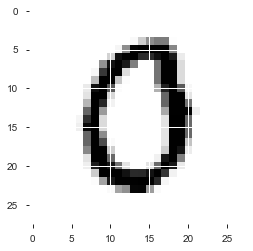

In [172]:
plt.imshow(df_test_image[100,:,:,0])

In [ ]:
# train test split

In [75]:
X_train_image, X_vad_image, Y_train_label, Y_vad_label =  train_test_split(df_train_image,df_train_label)

## tensor flow

In [42]:
# some values
image_size = df_train_X.shape[1]
image_height = 28
image_width = 28
num_exmaples = df_train_X.shape[0]
num_classes = df_train_Y.nunique()

### place holders for tensorflow

In [61]:
def create_placeholders(n_h, n_w, n_y, n_c):
    """
    create placeholders for tensorflow of input data and labels
    
    arguments:
    n_h: scaler, image_height
    n_w: scaler, image_width
    n_y: number of classes for classification
    n_c: input channels, =1 in this grey scale case
    
    return:
    X: placeholder for input, float, [None, n_h, n_w]
    Y: placeholder for target, float, [None, n_y]
    """
    X = tf.placeholder('float',shape = [None, n_h, n_w, n_c])
    Y = tf.placeholder('float',shape = [None, n_y])
    
    return X,Y
    

### intial weights for conv layers

In [43]:
def initial_weights():
    """
    initial weights for conv layers in tensorflow.shape=[height,weight,inputlayer#,#filter]
    since we have grey scale, input layer # is 1. try two conv layers W1, and W2
    
    W1: [4,4,1,8]
    W2: [2,2,8,16]
    
    Return:
    Weights- a dictionary of "W1" and "W2"
    
    """
    W1 = tf.get_variable("W1",[4,4,1,8],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2",[2,2,8,16],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    
    weights = {"W1": W1,
               "W2": W2}
    return weights

### forward prop

In [177]:
def forward_prop(X, weights):
    """
    implement forward propogation in tensor flow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    arguments:
    X: input dataset place holder
    weights: convNN weights
    
    return:
    Z3: last fully connected output without activation, shape = [num_class, num of examples]
    """
    # retrieve weights from weights
    W1 = weights["W1"]
    W2 = weights["W2"]
    # conv2d: stride=1 padding=same
    Z1 = tf.nn.conv2d(X,W1,strides = [1,1,1,1],padding='SAME')
    # relu
    A1 = tf.nn.relu(Z1)
    # maxpool window8x8,stride=8x8
    P1 = tf.nn.max_pool(A1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    # 2nd conv stride=1 padding=same
#    Z2 = tf.nn.conv2d(P1,W2,strides=[1,1,1,1],padding='SAME')
#     # 2nd relu
#     A2 = tf.nn.relu(Z2)
#     #2nd max pool windwo=4x4,stride = 4x4
#     P2 = tf.nn.max_pool(A2,ksize=[1,2,2,1],strides=[1,2,2,1],padding = 'SAME')
    # flatten
#    P = tf.contrib.layers.flatten(P2)
    P = tf.contrib.layers.flatten(P1)
    # fully connected layer without activation function
    Z3 = tf.contrib.layers.fully_connected(P,10,activation_fn=None)
    
    return Z3 

### compute cost

In [45]:
def compute_cost(Z3,Y):
    """
    compute the cost function
    
    arguments:
    Z3: output of forward prop, shape[num_classes,num_exmaples]
    Y: "true" labels placeholder, shape[num_classes,num_exmaples]
    
    return:
    cost: tensor of the cost
    """
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3,labels=Y))
    return cost
    

## create mini batches for model training

In [160]:
def random_mini_batches(X,Y,mini_batch_size=64,seed=0):
    """
    create random mini batches for tensorflow model training
    
    arguments:
    X: input training dataset, shape=[num_examples,n_h,n_w,n_c(=1 in this case)]
    Y: true labels of training dataset, shape=[num_examples,num_classes]
    
    return: list of random mini batches of ((minibatch_x_1,minibatch_y_1),...
                                            (minibatch_x_n,minibatch_y_n))
    
    """
    m = X.shape[0] #get num_examples
    mini_batches = []
    np.random.seed(seed)
    # step 1: shuffle the dataset
    permutation = np.random.permutation(m)
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]
    # step 2: partition the shuffled x,y, minus the end case
    num_complete_minibatches = int(np.floor(m/mini_batch_size))
    for k in range(int(num_complete_minibatches)):
        mini_batch_X = shuffled_X[k * mini_batch_size:k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size:k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    # handeling the end case
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X,mini_batch_Y)
        mini_batches.append(mini_batch)
    return mini_batches
        

## modeling


In [180]:
def model(X_train,Y_train,X_test,Y_test,learning_rate = 0.01,num_epochs=20,
          minibatch_size=64,print_cost=True):
    """
    implement tensorflow 3-layer CNN
    
    arguments:
    X_train: input training dataset, shape=[none,n_h,n_w,n_c]
    Y_train: labels of training data set, shape = [none,n_y]
    X_test: input test dataset, shape=[none,n_h,n_w,n_c]
    Y_test: labels of test data set, shape = [none,n_y]
    
    returns:
    train_accuracy
    test_accuracy
    weights: weights learned from model, can be used to predict
    """
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3    
    
    (m, n_H0, n_W0,n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    print(n_y)
    costs = []
    
    # START TENSORFLOW TO FORWARD PROP
    X,Y = create_placeholders(n_H0,n_W0,n_y,n_C0)
    weights = initial_weights()
    Z3 = forward_prop(X,weights)
    cost = compute_cost(Z3,Y)
    
    #OPTIMIZER: BACKPROP
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # start the flow
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            minibatch_cost = 0
            num_complete_minibatch = int(m % minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _, temp_cost = sess.run([optimizer,cost],feed_dict={X:minibatch_X,Y:minibatch_Y})
                minibatch_cost += temp_cost / num_complete_minibatch
        
            #print the cost every a few epoch
            if print_cost == True and epoch % 5 == 0:
                print("cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        # plot cost function
        plt.plot(np.squeeze(costs))
        plt.xlabel('iterations')
        plt.ylabel('cost')
        plt.show()
        
        #evaluation
        predict_op = tf.argmax(Z3,1)
        correct_prediction = tf.equal(predict_op,tf.argmax(Y,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction,"float"))
        train_accuracy = accuracy.eval({X:X_train,Y:Y_train})
        test_accuracy = accuracy.eval({X:X_test,Y:Y_test})
        
        print("train_accuracy",train_accuracy)
        print("test_accuracy",test_accuracy)
        
        return train_accuracy, test_accuracy, weights
            

10
cost after epoch 0: 8.335791
cost after epoch 5: 1.674887
cost after epoch 10: 0.901894
cost after epoch 15: 0.675792


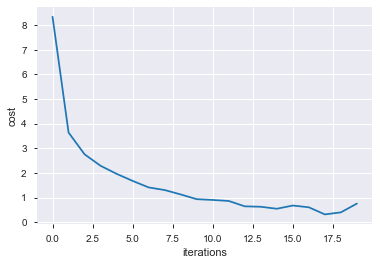

train_accuracy 0.99561906
test_accuracy 0.9766667


In [181]:
_, _, weights = model(X_train_image, Y_train_label, X_vad_image, Y_vad_label,learning_rate = 0.008)

In [184]:
tf.__version__

'1.13.1'

<tf.Variable 'W1:0' shape=(4, 4, 1, 8) dtype=float32_ref>